# 2D Constructive Solid Geometry (CSG) with GeoLIPI

This notebook showcases the use of GeoLIPI for Constructive Solid Geometry (CSG) in two dimensions (2D).

Union(
	Union(
		Difference(
			Rectangle2D(tensor([1.0000, 1.5000])),
			Union(
				Translate2D(
					Circle2D(tensor(0.2000)),
					tensor([-0.1500,  0.3000])),
				Translate2D(
					Rectangle2D(tensor([0.6000, 0.3000])),
					tensor([ 0.3000, -0.3000]))))),
	EulerRotate2D(
		Translate2D(
			IsoscelesTriangle2D(tensor([0.8500, 0.3500])),
			tensor([ 0.0000, -0.6500])),
		tensor(-1.5708)))


(-0.5, 255.5, 255.5, -0.5)

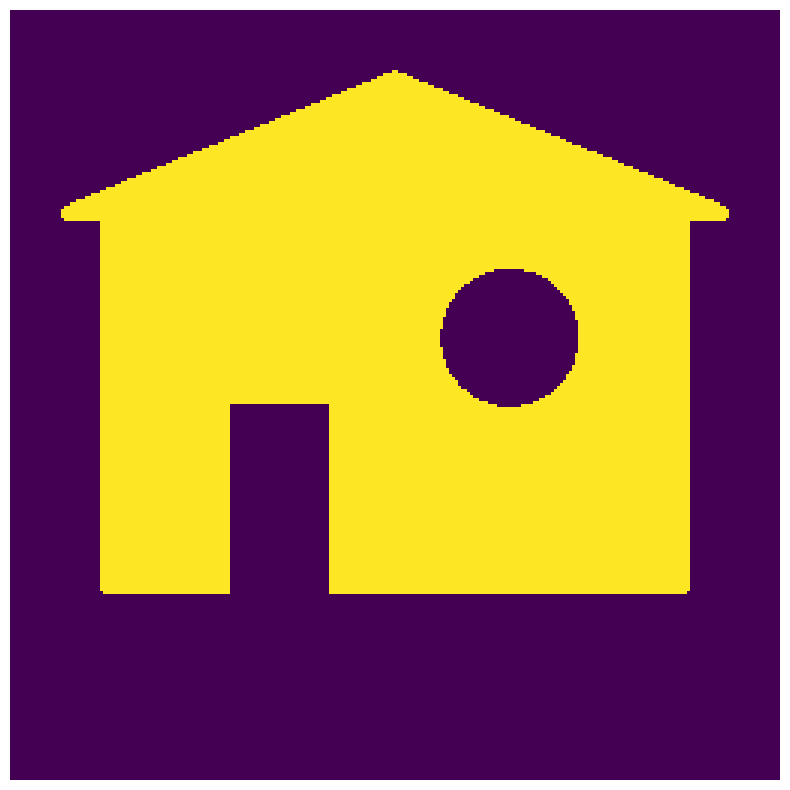

In [1]:
# 1.1 2D CSG
import numpy as np
import torch as th
import geolipi.symbolic as gls
from geolipi.torch_compute import expr_to_sdf
from geolipi.torch_compute import Sketcher
import matplotlib.pyplot as plt
%matplotlib inline

# A Simple CSG expression for a House
house_expr = gls.Union(
    # Body
    gls.Union(
        gls.Difference(
            gls.Rectangle2D((1, 1.5)),
            gls.Union(
                gls.Translate2D(gls.Circle2D((0.2)), (-0.15, 0.3)),
                gls.Translate2D(gls.Rectangle2D((0.6, 0.3)), (0.3, -0.3))
            )
       )
    ),
    # Roof
    gls.EulerRotate2D(
        gls.Translate2D(
            gls.IsoscelesTriangle2D((0.85, 0.35)), 
            (-0.0, -0.65)),
        (-np.pi/2)
    )
)

# Now to execute the expression, first convert all the variables to tensors. 
house_expr = house_expr.to_tensor()
# print the expression:
print(house_expr.cpu().pretty_print())

resolution = 256
# Get House sdf
sketcher = Sketcher(device="cuda", dtype=th.float32,
                 resolution=256, mode="direct", n_dims=2)

sdf = expr_to_sdf(house_expr, sketcher)
# use 0.02 to make the edges smoother.
occ = sdf <=0.02
occ = occ.reshape(resolution, resolution)
plt.figure(figsize=(10,10))
plt.imshow(occ.cpu().numpy())
# no axis
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

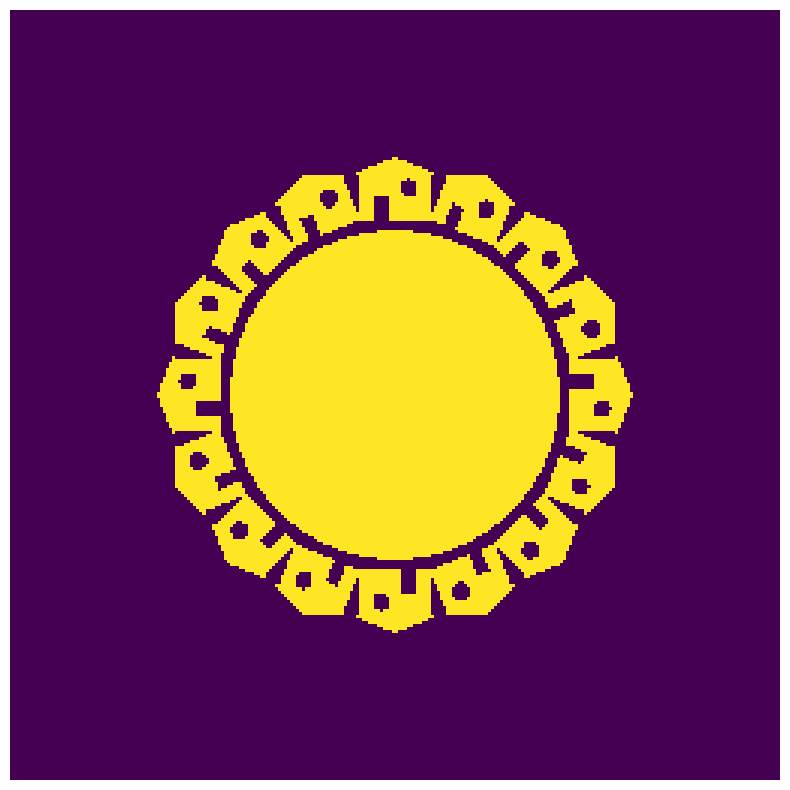

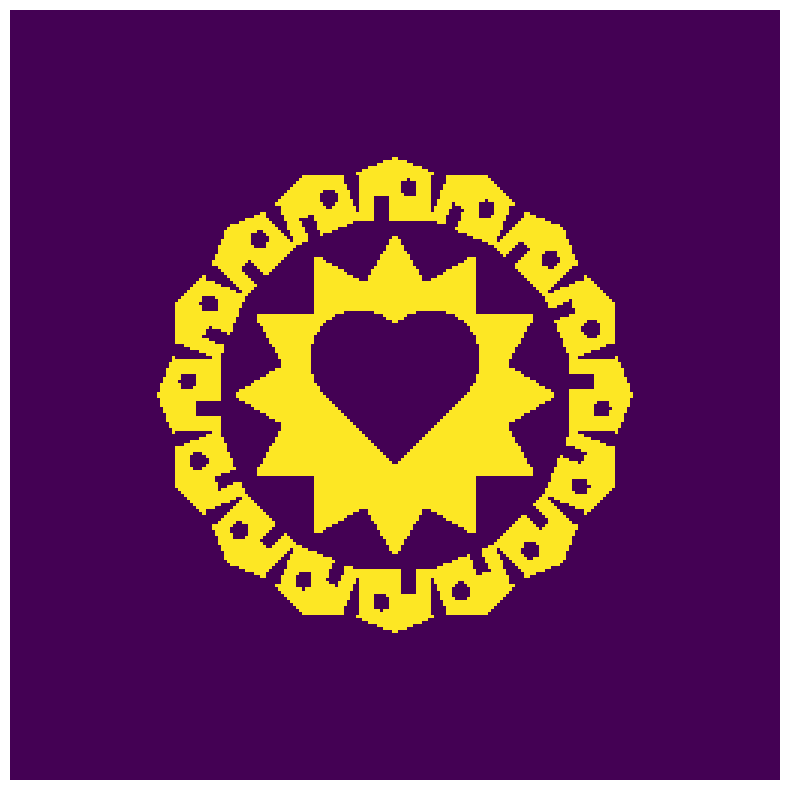

In [2]:
# 1.2 2D CSG Complex with Macros
globe_expr = gls.Union(
    gls.Circle2D((0.42,)),
    gls.RotationSymmetry2D(
        gls.Translate2D(
            gls.Scale2D(house_expr,
                        (0.12, 0.12)), 
            (-0.52, 0.0)
        ), (np.pi/8), 16)
)

globe_expr = globe_expr.to_tensor()

sdf = expr_to_sdf(globe_expr, sketcher)
# use 0.02 to make the edges smoother.
occ = sdf <=0.01
occ = occ.reshape(resolution, resolution)
plt.figure(figsize=(10,10))
plt.imshow(occ.cpu().numpy())
plt.axis('off')
# 1.3 2D CSG Advanced 2D CSG functions
heart_expr = gls.Difference(
        gls.RegularStar2D((0.55,), (12,), (4,)),
        gls.EulerRotate2D(gls.Scale2D(gls.Heart2D(), (0.5, 0.5)), (np.pi/2,))
)

globe_expr = gls.Union(
    gls.Scale2D(heart_expr,(0.75, 0.75)),
    gls.Scale2D(
    gls.Difference(
        gls.RegularStar2D((0.4,), (2,), (5.,)),
        gls.Heart2D()), (0.5, 0.5)),
    gls.RotationSymmetry2D(
        gls.Translate2D(
            gls.Scale2D(house_expr,
                        (0.12, 0.12)), 
            (-0.52, 0.0)
        ), (np.pi/8), 16)
)

globe_expr = globe_expr.to_tensor()

sdf = expr_to_sdf(globe_expr, sketcher)
# use 0.02 to make the edges smoother.
occ = sdf <=0.01
occ = occ.reshape(resolution, resolution)
plt.figure(figsize=(10,10))
plt.imshow(occ.cpu().numpy())
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

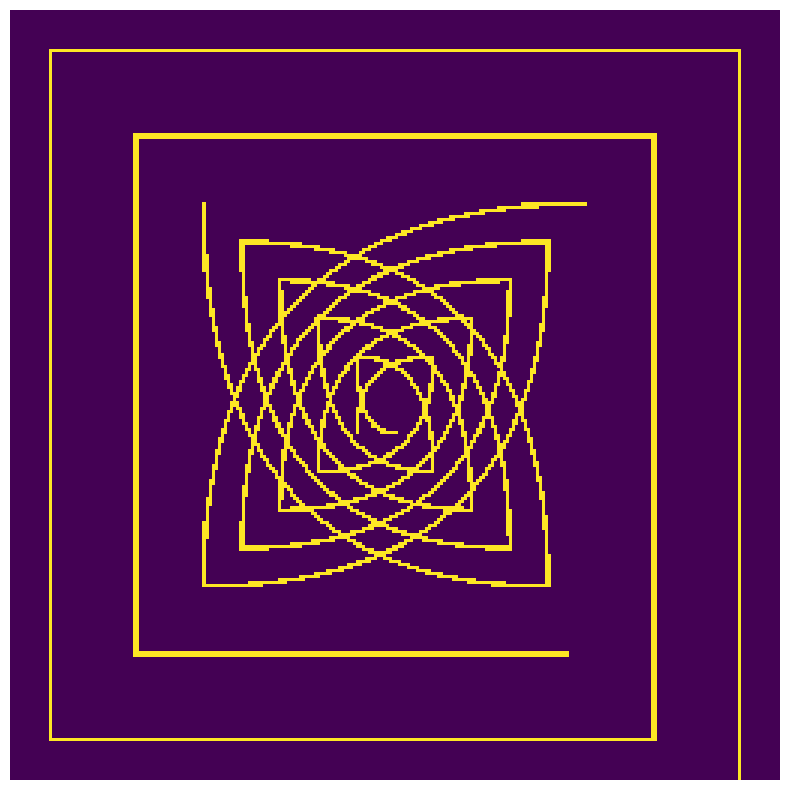

In [3]:
# 2: 3D Curves
all_points = [
    (-0.5, 0.5),
    (-0.5, -0.5),
    (0.5, -0.5),
    (0.5, 0.4),
    (-0.4, 0.4),
    (-0.4, -0.4),
    (0.4, -0.4),
    (0.4, 0.3),
    (-0.3, 0.3),
    (-0.3, -0.3),
    (0.3, -0.3),
    (0.3, 0.2),
    (-0.2, 0.2),
    (-0.2, -0.2),
    (0.2, -0.2),
    (0.2, 0.1),
    (-0.1, 0.1),
    (-0.1, -0.1),
    (0.1, -0.1),
    (0.1, 0.0),
]
lines = []
for ind in range(len(all_points) - 9):
    cur_line = gls.Segment2D(
        tuple([x * 30 for x in all_points[ind]]), 
        tuple([x * 30 for x in all_points[ind+1]]))
    lines.append(cur_line)

spiral_expr = gls.Scale2D(gls.Union(*lines), (0.075,0.075))

## With bezier curves
lines = []
for ind in range(len(all_points) -2):
    cur_line = gls.QuadraticBezierCurve2D(all_points[ind], all_points[ind+1], all_points[ind+2])
    lines.append(cur_line)

spiral_expr_2 = gls.Union(*lines)
spiral_expr_2 = spiral_expr_2

design = gls.Union(spiral_expr, spiral_expr_2)
design = design.to_tensor()
sdf = expr_to_sdf(design, sketcher)
# use 0.02 to make the edges smoother.
occ = sdf <=0.075
occ = occ.reshape(resolution, resolution)
plt.figure(figsize=(10,10))
plt.imshow(occ.cpu().numpy())
plt.axis('off')
